In [252]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.optimize import minimize

AperSigma = 40


C:\Users\Ctarg07\AppData\Local\Temp\ipykernel_6944\2501414989.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hw = float(self.h.T @ w)


MI_opt = 0.008513242232795815
AperSigma = 42
MI_opt = 0.021189547827433763
AperSigma = 44
MI_opt = 0.051992112149158665
AperSigma = 46
MI_opt = 0.12296298098594738
AperSigma = 48
MI_opt = 0.2675498674102412
AperSigma = 50
MI_opt = 0.5078469656061615
AperSigma = 52
MI_opt = 0.7694905611401999
AperSigma = 54
MI_opt = 1.0907743470983484
AperSigma = 56
MI_opt = 1.4790313542067506
AperSigma = 58
MI_opt = 1.9348125534282525
AperSigma = 60
MI_opt = 2.4454567537030063
AperSigma = 62
MI_opt = 3.0013517402516787
AperSigma = 64
MI_opt = 3.5431586070135945
AperSigma = 66
MI_opt = 3.9021932899624674
AperSigma = 68
MI_opt = 3.9973672213811944
AperSigma = 70
MI_opt = 3.9999994524552416
AperSigma = 72
MI_opt = 4.000000000000005
AperSigma = 74
MI_opt = 3.9999999999999987


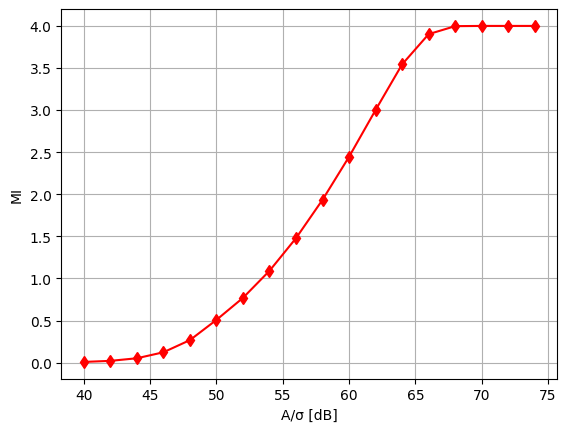

In [253]:
class MI_MISO_VLC:
    def __init__(self, M, AperSigmadB, alpha_over_N):
        self.N = 16 # Number of LEDs
        self.M = M
        self.Sigma = 1
        self.AperSigma = 10**(AperSigmadB/10)
        self.A = self.Sigma*self.AperSigma
        self.User_pos = np.array([0.7, 1.6, 0.85])
        self.room_dimensions = np.array([5, 5, 3])
        self.conversion_efficiency = 0.73
        self.Lambertian_order = 1
        self.refractive_index = 1.5
        self.A_PD = 1.0e-4
        self.FOV = (70/180)*np.pi
        self.R = 0.54
        self.optical_gain = 1
        self.LED_pos = self.get_LED_position()
        self.distance = self.get_distance()
        self.angle = self.get_angle()
        self.h = self.get_channelgain()
        self.a = np.array([(i-1)*self.A/(self.M-1) for i in range(1, self.M + 1)]) #Pam constellation
        self.p_uni = np.array([1/self.M for i in range(self.M)]) #probability vector
        self.w_uni = np.ones((self.N, 1))  #tạm thời để bằng 1 size = (16, 1)
        self.MI_uni = self.get_MI(self.p_uni, self.w_uni)
        self.MI_approx_uni = self.get_MI_approx(self.p_uni, self.w_uni)
        self.alpha_over_N = alpha_over_N
        self.P = self.alpha_over_N * self.A * self.N 
        self.alpha = self.P/self.A
        self.MI_opt, self.p_opt, self.w_opt = self.JPSB()
        print(f'MI_opt = {self.MI_opt}')

    def get_LED_position(self): #mới chỉ đang đúng cho 16LED, phải sửa lại cho các số LED khác
        nx = int(np.sqrt(self.N))
        ny = int(np.sqrt(self.N))
        x = np.linspace(1, nx, num=nx)
        y = np.linspace(1, ny, num=ny)
        led_positions = np.zeros([nx, ny, 3])
        for i in range(nx):
            for j in range(ny):
                led_positions[i, j] = np.array([x[i], y[j], 3])
        led_positions = led_positions.reshape(self.N, 3)
        return np.array(led_positions)
    
    def get_distance(self):
        D = np.zeros((self.N, 1))
        for i in range(self.N):
            vector = self.LED_pos[i] - self.User_pos
            D[i] = np.linalg.norm(vector)
        return D
    
    def get_angle(self):
        A = np.zeros((self.N, 1))
        for i in range(self.N):
            A[i] = np.arccos((self.room_dimensions[2]-self.User_pos[2]) / self.distance[i])
        return A
    
    def get_channelgain(self):
        H = np.zeros((self.N, 1))
        for i in range(self.N):
            if self.angle[i] <= self.FOV:
                a = self.conversion_efficiency*(self.Lambertian_order + 1)
                b = self.refractive_index**2 * self.A_PD * np.cos(self.angle[i])**self.Lambertian_order * np.cos(self.angle[i])*self.R*self.optical_gain
                c = (2*np.pi*self.distance[i]**2)*(np.sin(self.FOV)**2)
                H[i] = a*b/c
            else:
                H[i] = 0
        return H
    
    def get_MI(self, p, w):
        hw = self.h.T @ w
        def pdf_y(y):
            f_y = 0
            for i in range(self.M):
                f_y += (1 / np.sqrt(2 * np.pi * self.Sigma**2)) * p[i] * np.exp(-(y - hw * self.a[i])**2 / (2 * self.Sigma**2))
            if f_y < 1e-300:
                f_y = 1e-300
            return -f_y * np.log2(f_y)
        MI = quad(pdf_y, -1500, 1500, limit=5000)[0] - 0.5 * np.log2(2 * np.pi * np.e * self.Sigma**2)
        return MI 

    def get_MI_approx(self, p, w):
        Nsamples = 10000
        s = np.random.choice(self.a, size=Nsamples, p=p)
        hw = float(self.h.T @ w)
        x = hw * s
        y = x + np.random.normal(0, self.Sigma, size=Nsamples)

        qY = np.zeros(Nsamples)
        for i in range(self.M):
            qY += p[i] * (1 / np.sqrt(2 * np.pi * self.Sigma**2)) * np.exp(-(y - hw * self.a[i])**2 / (2 * self.Sigma**2))

        qY = np.clip(qY, 1e-300, None)
        pYonX = (1 / np.sqrt(2 * np.pi * self.Sigma**2)) * np.exp(-(y - x)**2 / (2 * self.Sigma**2))
        I = (1/Nsamples)*np.sum(np.log2(pYonX / qY))
        return I
    
    def solve_P2a(self, gamma): #solve P2.a using closed_form
        h = self.h.flatten()
        sorted_idx = np.argsort(h)[::-1]
        w = np.zeros(self.N)
        remaining_gamma = gamma
        n_g = 0
        for i in sorted_idx:
            if remaining_gamma > 1:
                w[i] = 1
                remaining_gamma -= 1
                n_g += 1
            else:
                break
            if remaining_gamma > 0:
                n_e = 1
                w[sorted_idx[n_g]] = remaining_gamma
        return w.reshape(-1, 1)
    
    
    def solve_P2b(self, w, gamma):
        def objective(p):
            return -self.get_MI(p, w)
        constraints = [
            {'type': 'eq', 'fun': lambda p: np.sum(p) - 1},  # sum(p) = 1
            {'type': 'ineq', 'fun': lambda p: self.P - self.a @ p * gamma}  # a^T p γ ≤ P
        ]
        bounds = [(0, 1) for _ in range(self.M)]
        p0 = np.ones(self.M) / self.M
        result = minimize(objective, p0, method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x, -result.fun
    
    def JPSB(self, delta=5e-2):
        gamma_l = 0
        gamma_r = self.N
        phi = (1+np.sqrt(5))/2
        while gamma_r - gamma_l > delta:
            gamma_1 = gamma_r - (gamma_r - gamma_l)/phi
            gamma_2 = gamma_l + (gamma_r - gamma_l)/phi

            w1 = self.solve_P2a(gamma_1)
            p1,_ = self.solve_P2b(w1, gamma_1)
            R1 = self.get_MI(p1, w1)

            w2 = self.solve_P2a(gamma_2)
            p2,_ = self.solve_P2b(w2, gamma_2)
            R2 = self.get_MI(p2, w2)
            
            if R1>R2:
                gamma_r = gamma_2
            else:
                gamma_l = gamma_1
        
        gamma_opt = (gamma_l + gamma_r)/2
        w_opt = self.solve_P2a(gamma_opt)
        p_opt,_ = self.solve_P2b(w_opt, gamma_opt)
        MI_opt = self.get_MI(p_opt, w_opt)
        return MI_opt, p_opt, w_opt 



A_Sigma_dB = np.arange(40, 75, 2)
mi_16pam_opt = np.zeros_like(A_Sigma_dB, dtype=float)

    
for i in range(len(A_Sigma_dB)):
    print(f'AperSigma = {A_Sigma_dB[i]}')
    mi_16pam_opt[i] = MI_MISO_VLC(16, A_Sigma_dB[i],0.1).MI_opt
    
# for i in range(len(A_Sigma_dB)-25):
    # if mi_4pam[i+25]<mi_4pam[i+24]:
    #     mi_4pam[i+25] = mi_4pam[i+24]
    # if mi_16pam[i+25]<mi_16pam[i+24]:
    #     mi_16pam[i+25] = mi_16pam[i+24]
    # if mi_64pam[i+25]<mi_64pam[i+24]:
    #     mi_64pam[i+25] = mi_64pam[i+24]




plt.plot(A_Sigma_dB, mi_16pam_opt, 'r', marker='d')

plt.xlabel('A/σ [dB]')
plt.ylabel('MI')
plt.grid()
plt.show()



C:\Users\Ctarg07\AppData\Local\Temp\ipykernel_6944\2501414989.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  hw = float(self.h.T @ w)


MI_opt = 1.2755515527703247


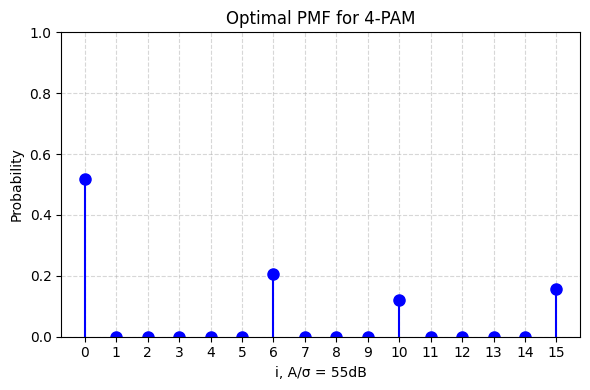

In [254]:
cam = MI_MISO_VLC(16, 55, 0.1)
p = cam.p_opt
w = cam.w_opt
x = np.arange(len(p))  

plt.figure(figsize=(6, 4))
for xi, yi in zip(x, p):
    plt.plot([xi, xi], [0, yi], color='blue', linewidth=1.5) 
    plt.plot(xi, yi, 'o', color='blue', markersize=8) 

plt.xlabel("i, A/σ = 55dB")
plt.ylabel("Probability")
plt.title("Optimal PMF for 4-PAM")
plt.xticks(x)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

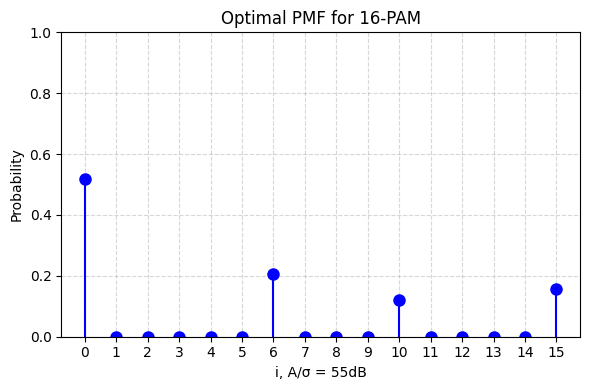

In [255]:
plt.figure(figsize=(6, 4))
for xi, yi in zip(x, p):
    plt.plot([xi, xi], [0, yi], color='blue', linewidth=1.5) 
    plt.plot(xi, yi, 'o', color='blue', markersize=8) 

plt.xlabel("i, A/σ = 55dB")
plt.ylabel("Probability")
plt.title("Optimal PMF for 16-PAM")
plt.xticks(x)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

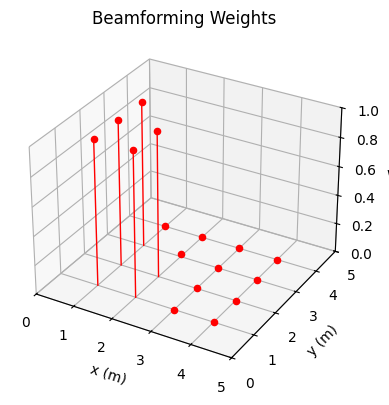

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_LED_position(): 
    nx = int(np.sqrt(16))
    ny = int(np.sqrt(16))
    x = np.linspace(1, nx, num=nx)
    y = np.linspace(1, ny, num=ny)
    led_positions = np.zeros([nx, ny, 3])
    for i in range(nx):
        for j in range(ny):
            led_positions[i, j] = np.array([x[i], y[j], 3])
    led_positions = led_positions.reshape(16, 3)
    return np.array(led_positions)

led_pos = get_LED_position()  

w = cam.w_opt

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(w)):
    x, y, _ = led_pos[i]
    zi = w[i].item()  # Sửa tại đây nếu w[i] là ndarray 1 phần tử
    ax.plot([x, x], [y, y], [0, zi], color='red', linewidth=1)
    ax.scatter(x, y, zi, color='red')


ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("wₖ")
ax.set_title("Beamforming Weights")
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_zlim(0, 1)

plt.tight_layout()
plt.show()
